Dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

Goal: Train 3 binary text-classfication models to detect Fake/True news

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from string import punctuation
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.preprocessing import text, sequence
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
#nltk.download('wordnet')
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier

C:\Users\NTU\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\NTU\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
true = pd.read_csv("True.csv")
false = pd.read_csv("Fake.csv")

In [3]:
# Create a new column for the label we are predicting
true['category'] = 1
false['category'] = 0

# Merge the two datasets
df = pd.concat([true,false])

In [4]:
# Drop rows with empty elements
df = df.dropna()

# Drop duplicate rows
df = df.drop_duplicates()

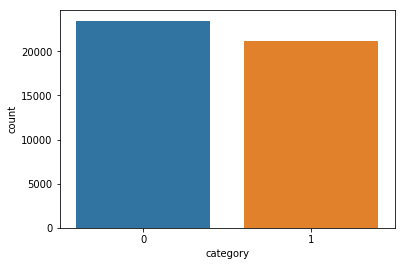

In [5]:
sns.countplot(df.category)

Thus, the dataset is balanced, no need to do re-sampling.

In [6]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [7]:
# Merge column "title" and "text"
df['text'] = df['title'] + ' ' + df['text']
df = df.drop(columns=['title', 'subject', 'date'])

In [8]:
# Remove stopwords, punctuations and single-character words from the text
stop = set(stopwords.words('english'))
punctuation = list(punctuation)
stop.update(punctuation)

In [18]:
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and len(i)>1:
            final_text.append(i.strip())
    return " ".join(final_text)

df['text']=df['text'].apply(remove_stopwords)

In [36]:
# Split the data into training and testing data
x_train,x_test,y_train,y_test = train_test_split(df.text, df.category, random_state = 0)

# Model 1: GloVe + LSTM

GloVe: an unsupervised learning algorithm for obtaining vector representations for words through training on aggregated global word-word co-occurrence statistics from a corpus.

LSTM: a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

Code source: https://www.kaggle.com/madz2000/nlp-using-glove-embeddings-99-87-accuracy/notebook#Introduction-to-GloVe

In [37]:
# Tokenize Text (Repsesent each word by a number)
max_features = 10000
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)
# Keep all news to exact 300 words
maxlen = 300
tokenized_train = tokenizer.texts_to_sequences(x_train)
x_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [38]:
# Load the embedding file
def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')

EMBEDDING_FILE = 'glove.twitter.27B.100d.txt'
# Map each word to its word vector
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, 'r', encoding='UTF-8'))

In [39]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
#change below line if computing normal stats is too slow
embedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

C:\Users\NTU\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2903: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


In [44]:
# Model parameters
batch_size = 256
epochs = 5
embed_size = 100

In [45]:
# Define the Neural Network
model = Sequential()
# Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, weights=[embedding_matrix], input_length=maxlen, trainable=False))
# LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
# Train the model
model.fit(x_train, y_train, batch_size = batch_size , validation_data = (X_test,y_test) , epochs = epochs)

Epoch 1/5
131/131 [==============================] - 1489s 11s/step - loss: 0.3179 - accuracy: 0.8457 - val_loss: 0.0627 - val_accuracy: 0.9793
Epoch 2/5
131/131 [==============================] - 1602s 12s/step - loss: 0.0678 - accuracy: 0.9783 - val_loss: 0.0290 - val_accuracy: 0.9912
Epoch 3/5
131/131 [==============================] - 1635s 12s/step - loss: 0.0349 - accuracy: 0.9878 - val_loss: 0.0250 - val_accuracy: 0.9917
Epoch 4/5
131/131 [==============================] - 1680s 13s/step - loss: 0.0277 - accuracy: 0.9904 - val_loss: 0.0251 - val_accuracy: 0.9918
Epoch 5/5
131/131 [==============================] - 1727s 13s/step - loss: 0.0192 - accuracy: 0.9934 - val_loss: 0.0253 - val_accuracy: 0.9900


In [47]:
y_pred = model.predict_classes(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average="macro"))

C:\Users\NTU\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy:  0.9899758346012709
F1 score:  0.9899431456167861


# Model 2: Word2Vec + LSTM

Word2Vec: a technique to learn word embeddings from a large corpus of text using shallow neural network model.

LSTM: a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

Code Source: https://www.kaggle.com/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

In [9]:
y = df['category'].values
# Convert X to format acceptable by gensim, remove stopwords and punctuations in the process
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [10]:
EMBEDDING_DIM = 100

# Create word vectors using Word2Vec method 
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [11]:
# Tokenize text: Repsesent each word by a number
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [12]:
# Keep all news length to 700
maxlen = 700 
X = pad_sequences(X, maxlen=maxlen)

In [13]:
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1
word_index = tokenizer.word_index

# Create weight matrix from word2vec model
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [14]:
# Define the Neural Network
model = Sequential()
# Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
# LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [15]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y) 

# Train the model
model.fit(X_train, y_train, validation_split=0.3, epochs=5)

Epoch 1/5
734/734 [==============================] - 733s 994ms/step - loss: 0.1719 - acc: 0.9371 - val_loss: 0.0404 - val_acc: 0.9893
Epoch 2/5
734/734 [==============================] - 654s 892ms/step - loss: 0.0500 - acc: 0.9838 - val_loss: 0.0159 - val_acc: 0.9951
Epoch 3/5
734/734 [==============================] - 562s 765ms/step - loss: 0.0128 - acc: 0.9970 - val_loss: 0.0111 - val_acc: 0.9971
Epoch 4/5
734/734 [==============================] - 550s 750ms/step - loss: 0.0070 - acc: 0.9983 - val_loss: 0.0181 - val_acc: 0.9962
Epoch 5/5
734/734 [==============================] - 502s 683ms/step - loss: 0.0070 - acc: 0.9978 - val_loss: 0.0256 - val_acc: 0.9927


In [16]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average="macro"))

Accuracy:  0.9958829320683791
F1 score:  0.9958718461057823


# Model 3: TF-iDF + RandomForest

TF-iDF: a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

RandomForest: a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

Code Source: https://www.kaggle.com/rahulvv/nb-and-rf-models-99-accuracy

In [8]:
X_data = df['text'].values
y_data = df['category']

In [9]:
# Clean and process text data
def final(X_data_full):
    
    # function for removing punctuations
    def remove_punct(X_data_func):
        string1 = X_data_func.lower()
        translation_table = dict.fromkeys(map(ord, punctuation),' ')
        string2 = string1.translate(translation_table)
        return string2
    
    X_data_full_clear_punct = []
    for i in range(len(X_data_full)):
        test_data = remove_punct(X_data_full[i])
        X_data_full_clear_punct.append(test_data)
        
    # function to remove stopwords
    def remove_stopwords(X_data_func):
        pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
        string2 = pattern.sub(' ', X_data_func)
        return string2
    
    X_data_full_clear_stopwords = []
    for i in range(len(X_data_full)):
        test_data = remove_stopwords(X_data_full[i])
        X_data_full_clear_stopwords.append(test_data)
        
    # function for tokenizing
    def tokenize_words(X_data_func):
        words = nltk.word_tokenize(X_data_func)
        return words
    
    X_data_full_tokenized_words = []
    for i in range(len(X_data_full)):
        test_data = tokenize_words(X_data_full[i])
        X_data_full_tokenized_words.append(test_data)
        
    # function for lemmatizing
    lemmatizer = WordNetLemmatizer()
    def lemmatize_words(X_data_func):
        words = lemmatizer.lemmatize(X_data_func)
        return words
    
    X_data_full_lemmatized_words = []
    for i in range(len(X_data_full)):
        test_data = lemmatize_words(X_data_full[i])
        X_data_full_lemmatized_words.append(test_data)
        
    # creating the bag of words model
    cv = CountVectorizer(max_features=1000)
    X_data_full_vector = cv.fit_transform(X_data_full_lemmatized_words).toarray()
    
    
    tfidf = TfidfTransformer()
    X_data_full_tfidf = tfidf.fit_transform(X_data_full_vector).toarray()
    
    return X_data_full_tfidf

data_X = final(X_data)

In [10]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(data_X, y_data)

In [11]:
# Use Random Forest model
rfc = RandomForestClassifier(n_estimators= 10)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
y_pred = rfc.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1 score: ', f1_score(y_test, y_pred, average="macro"))

Accuracy:  0.9951669202541842
F1 score:  0.9951604985566729


# Summary

| Model | Emedding Model | Classification Model | Accuracy | F1 Score |
| -: | -: | -: | -: | -: |
| Model 1: GloVe + LSTM | GloVe | LSTM | 0.9899758346012709 | 0.9899431456167861 |
| Model 2: Word2Vec + LSTM | Word2Vec | LSTM | __0.9958829320683791__ | __0.9958718461057823__ |
| Model 3: TF-iDF + RandomForest | TF-iDF | Random Forest | 0.9951669202541842 | 0.9951604985566729 |

Most preferred: Model 2: Word2Vec + LSTM

Reason for choosing each model:
> Model 1: GloVe + LSTM
- GloVe: This technique derives semantic relationships between words from the co-occurrence matrix. It does not rely just on local context information of words (compared with Word2Vec), so that it incorporates global statistics to obtain word vectors.
- LSTM: LSTM introduces more controlling knobs (than traditional RNN), which control the flow and mixing of inputs. Thus, LSTM can understand context along with recent dependency to help solve this classification problem. Also, it is good at dealing with the vanishing gradient problem while training.

> Model 2: Word2Vec + LSTM
- Word2Vec: This is one of the most popular technique to learn word embeddings. It captures context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

> Model 3: TF-iDF + RandomForest
- TF-iDF: TF-iDF computes word frequency scores that highlight words that are most interested. In this case, it can be a good method to encode news.
- Random Forest: RF consists of multiple single decision trees (each based on a random sample of the training data) and uses averaging to improve accuracy and control over-fitting. It is generally more accurate and stable than single trees. Therefore, it is a good choice for classification problems among large dataset.